# TSP: Clustering + Simulated Annealing

## Simulated Annealing Example

### Setting up

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import copy

In [2]:
class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __str__(self):
        return f"({self.x}, {self.y})"
    
    def __repr__(self):
        return f"({self.x}, {self.y})"
    
    def points(self):
        return [self.x, self.y]
    
    def __lt__(self, other):
        return self.x < other.x if self.x != other.x else self.y < other.y
    
    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __eq__(self, other):
        if not isinstance(other, Vertex):
            return False
        return (self.x, self.y) == (other.x, other.y)

In [3]:
# Function to calculate the total cost of a TSP tour
def calculate_tour_cost(solution, isCenter):
    if isCenter:
        solution = [vertex[1] for vertex in solution]
    cost = 0
    for i in range(len(solution) - 1):
        cost += solution[i].distance_to(solution[i + 1])
    cost += solution[-1].distance_to(solution[0])  # Complete the loop
    return cost

### Hyperparameters

In [4]:
num_vertices = 50
num_test_cases = 1
data_path = f'./tsp-data/tsp{num_vertices}_test_concorde.txt'
isRandomPick = True

### Load data

In [5]:
def read_data(data_path, num_repeat, shuffle=True):
    with open(data_path, 'r') as file:
        data = [line.strip() for line in file.readlines()]

        if shuffle:
            random.shuffle(data)
        
        test_cases, optimums = [], []

        for i in range(num_repeat):
            line = data[i].split()
            line, answer = line[:line.index('output')], line[line.index('output')+1:]
            test_case = []
            for j in range(0, len(line), 2):
                test_case.append(Vertex(float(line[j]), float(line[j+1])))
            test_cases.append(test_case)
        
            optimum = []
            for ind in answer:
                ind = int(ind) - 1
                optimum.append(test_case[ind])
            optimums.append(optimum)

        return test_cases, optimums

test_cases, optimums = read_data(data_path, num_test_cases, isRandomPick)

### Simulated Annealing algorithm for TSP

In [6]:
def simulated_annealing_tsp(cities, isCenter, initial_temp=5000, cooling_rate=0.99, max_iterations=1500, begin_with_random=True):
    """
    Simulated Annealing algorithm for solving TSP.
    
    Parameters:
        cities (list): List of Vertex objects representing the cities.
        initial_temp (float): Initial temperature for the annealing process.
        cooling_rate (float): Rate at which the temperature decreases.
        max_iterations (int): Maximum number of iterations for the algorithm.
        begin_with_random (bool): Whether to start with a random route or the given order.

    Returns:
        tuple: Best route (list of Vertex objects) and its associated distance (float).
    """

    # Helper functions
    def get_neighbors(route):
        """Generate a neighboring route using one of four operations."""
        neighbor = copy.deepcopy(route)
        operation = random.choice([inverse, insert, swap, swap_routes])
        operation(neighbor)
        return neighbor

    def inverse(route):
        """Reverse the order of cities between two random indices."""
        i, j = sorted(random.sample(range(len(route)), 2))
        route[i:j] = route[i:j][::-1]

    def insert(route):
        """Remove a random city and insert it before another city."""
        node = route.pop(random.randint(0, len(route) - 1))
        route.insert(random.randint(0, len(route) - 1), node)

    def swap(route):
        """Swap two random cities."""
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]

    def swap_routes(route):
        """Move a subroute to a new position in the route."""
        i, j = sorted(random.sample(range(len(route)), 2))
        subroute = route[i:j]
        del route[i:j]
        insert_pos = random.randint(0, len(route) - 1)
        route[insert_pos:insert_pos] = subroute

    # Initialize solution
    current_solution = random.sample(cities, len(cities)) if begin_with_random else cities[:]
    current_cost = calculate_tour_cost(current_solution, isCenter)
    best_solution, best_cost = current_solution[:], current_cost

    temp = initial_temp
    same_solution = 0
    same_cost_diff = 0

    while same_solution < max_iterations and same_cost_diff < 150000:
        # Generate a neighboring solution
        neighbor = get_neighbors(current_solution)
        neighbor_cost = calculate_tour_cost(neighbor, isCenter)

        cost_diff = neighbor_cost - current_cost
        if cost_diff < 0:  # Better solution
            current_solution, current_cost = neighbor, neighbor_cost
            same_solution = 0
            same_cost_diff = 0
        elif cost_diff == 0:  # Same cost, accept neighbor
            current_solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        else:  # Worse solution, accept with probability
            if random.random() < math.exp(-cost_diff / temp):
                current_solution, current_cost = neighbor, neighbor_cost
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1

        # Update the best solution found
        if current_cost < best_cost:
            best_solution, best_cost = current_solution[:], current_cost

        # Decrease temperature
        temp *= cooling_rate

    return best_solution, best_cost

In [7]:
def plot_tsp_solution(cities, sa_solution, reference_solution, sa_cost, reference_cost):
    """
    Plots the cities and their respective TSP tours, showing the result of the simulated annealing solution and the reference solution.
    
    :param cities: List of Vertex objects (cities in the TSP problem).
    :param sa_solution: List of Vertex objects representing the solution found by simulated annealing.
    :param reference_solution: List of Vertex objects representing the optimal reference solution.
    :param sa_cost: Cost of the solution found by simulated annealing.
    :param reference_cost: Cost of the reference solution.
    """
    
    # Create a figure and axis for plotting
    plt.figure(figsize=(10, 8))
    
    # Plot the cities
    x_vals = [city.x for city in cities]
    y_vals = [city.y for city in cities]
    plt.scatter(x_vals, y_vals, color='blue', label="Cities", zorder=5)

    # Plot the Simulated Annealing solution
    sa_x = [city.x for city in sa_solution] + [sa_solution[0].x]
    sa_y = [city.y for city in sa_solution] + [sa_solution[0].y]
    plt.plot(sa_x, sa_y, color='green', linewidth=2, label=f"SA Tour (Cost: {sa_cost:.2f})", zorder=4)

    # Plot the reference solution
    ref_x = [city.x for city in reference_solution] + [reference_solution[0].x]
    ref_y = [city.y for city in reference_solution] + [reference_solution[0].y]
    plt.plot(ref_x, ref_y, color='red', linewidth=3, linestyle='--', label=f"Reference Tour (Cost: {reference_cost:.2f})", zorder=3)
    
    # Annotate the cities
    # for i, city in enumerate(cities):
    #     plt.text(city.x + 0.01, city.y + 0.01, f"{i+1}", fontsize=9, ha='center', color='black')

    # Add labels and title
    plt.title(f"TSP Solution Comparison", fontsize=16)
    plt.xlabel("X Coordinate", fontsize=14)
    plt.ylabel("Y Coordinate", fontsize=14)
    
    # Add a legend
    plt.legend(loc='upper left', fontsize=12)

    # Set the limits to the [0, 1] range for both axes
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Show grid
    plt.grid(True)

    # Show the plot
    plt.show()


In [8]:
# for test_case, optimum in zip(test_cases, optimums):
#     sa_solution, sa_cost = simulated_annealing_tsp(test_case, False)
#     reference_cost = calculate_tour_cost(optimum, False)
#     print("Rate =", sa_cost/reference_cost)
    
#     plot_tsp_solution(test_case, sa_solution, optimum, sa_cost, reference_cost)

## Combine with Clustering Technique

### A HUGE Input

In [9]:
num_vertices = 100
num_clusters = 'default'
clustering_method = 'spectral' # 'kmeans', 'hierarchical', 'spectral', 'greedy'

### Generate Clusters

In [10]:
def set_parameters(num_vertices, num_clusters):
    data_path = f'./tsp-data/tsp{num_vertices}_test_concorde.txt'
    if not isinstance(num_clusters, int):
        num_clusters = round((num_vertices * 0.5) ** 0.5)
    return data_path, num_clusters

data_path, num_clusters = set_parameters(num_vertices, num_clusters)
test_cases, optimums = read_data(data_path, 1)

In [11]:
# --- Utility Functions for Clustering ---
def prepare_data(vertices):
    """
    Converts a list of Vertex objects to a 2D NumPy array suitable for clustering.
    """
    return np.array([[v.x, v.y] for v in vertices])

def assign_clusters(vertices, selected_vertices):
    """
    Assigns each vertex to the nearest selected vertex (greedy approach).
    """
    assignments = {}
    for v in vertices:
        closest_vertex = min(selected_vertices, key=lambda sv: v.distance_to(sv))
        assignments[v] = closest_vertex
    return assignments

def plot_clusters(vertices, cluster_assignments, selected_vertices):
    """
    Visualizes the clusters with unique colors for each. 
    The centroids are marked with a special marker.
    """
    # Generate a color map based on the number of clusters
    colors = plt.cm.tab10 if len(set(cluster_assignments.values())) <= 10 else plt.cm.tab20
    clusters = defaultdict(list)

    # Group vertices by cluster ID
    for vertex, cluster in cluster_assignments.items():
        clusters[cluster].append(vertex)

    # Plot the points for each cluster
    for idx, (cluster_id, points) in enumerate(clusters.items()):
        xs = [p.x for p in points]
        ys = [p.y for p in points]
        plt.scatter(xs, ys, color=colors(idx / len(clusters)), label=f"Cluster {cluster_id}")

    # Plot the centroids with a special marker (e.g., 'X' marker)
    for cluster_id, centroid in selected_vertices.items():
        plt.scatter(centroid.x, centroid.y, color='black', marker='X', s=100, label=f"Centroid {cluster_id}")

# --- Greedy Clustering Implementation ---
def greedy_clustering(vertices, num_clusters):
    selected_vertices = []
    pick = random.sample(vertices, 1)[0]
    selected_vertices.append(pick)
    
    while len(selected_vertices) < num_clusters:
        max_distance = -np.inf
        furthest_vertex = None
        for v in vertices:
            min_distance = min(v.distance_to(p) for p in selected_vertices)
            if min_distance > max_distance:
                max_distance = min_distance
                furthest_vertex = v
        selected_vertices.append(furthest_vertex)
    
    cluster_assignments = {}
    for v in vertices:
        closest_vertex = min(selected_vertices, key=lambda sv: v.distance_to(sv))
        cluster_id = selected_vertices.index(closest_vertex)
        cluster_assignments[v] = cluster_id
    
    # Calculate centroids for each cluster
    centroids = {}
    for cluster_id in range(num_clusters):
        cluster_points = [v for v, cid in cluster_assignments.items() if cid == cluster_id]
        if cluster_points:
            avg_x = np.mean([v.x for v in cluster_points])
            avg_y = np.mean([v.y for v in cluster_points])
            centroids[cluster_id] = Vertex(avg_x, avg_y)
    
    return cluster_assignments, centroids


# --- K-Means Clustering Implementation ---
def kmeans_clustering(vertices, num_clusters):
    data = prepare_data(vertices)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)
    cluster_assignments, selected_vertices = assign_results(vertices, kmeans.labels_, kmeans.cluster_centers_)
    return cluster_assignments, selected_vertices

# --- Hierarchical Clustering Implementation --- 
def hierarchical_clustering(vertices, num_clusters):
    data = prepare_data(vertices)
    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    labels = agglomerative.fit_predict(data)
    cluster_assignments, selected_vertices = assign_results(vertices, labels)  # Now this computes centroids
    return cluster_assignments, selected_vertices

# --- Spectral Clustering Implementation --- 
def spectral_clustering(vertices, num_clusters):
    data = prepare_data(vertices)
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(data)
    cluster_assignments, selected_vertices = assign_results(vertices, labels)  # Now this computes centroids
    return cluster_assignments, selected_vertices

# --- Helper Function to Assign Clustering Results ---
def assign_results(vertices, labels, centers=None):
    cluster_assignments = {v: labels[i] for i, v in enumerate(vertices)}
    
    # Map cluster index to its centroid
    centroids = {}
    if centers is not None:
        for i, center in enumerate(centers):
            centroids[i] = Vertex(center[0], center[1])  # Convert array to Vertex object
    else:
        # Calculate centroids based on cluster assignments (in case of Agglomerative and Spectral)
        num_clusters = len(set(labels))  # Number of clusters
        for cluster_id in range(num_clusters):
            cluster_points = [v for i, v in enumerate(vertices) if labels[i] == cluster_id]
            if cluster_points:
                avg_x = np.mean([v.x for v in cluster_points])
                avg_y = np.mean([v.y for v in cluster_points])
                centroids[cluster_id] = Vertex(avg_x, avg_y)

    return cluster_assignments, centroids

# --- Main Function to Run Any Clustering Method ---
def run_clustering(vertices, num_clusters, method='kmeans', show_plot=False, **kwargs):
    if method == 'kmeans':
        cluster_assignments, selected_vertices = kmeans_clustering(vertices, num_clusters)
    elif method == 'hierarchical':
        cluster_assignments, selected_vertices = hierarchical_clustering(vertices, num_clusters)
    elif method == 'spectral':
        cluster_assignments, selected_vertices = spectral_clustering(vertices, num_clusters)
    elif method == 'greedy':
        cluster_assignments, selected_vertices = greedy_clustering(vertices, num_clusters)
    else:
        raise ValueError(f"Unknown clustering method: {method}")

    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)
        plt.title(f"{method.capitalize()} Clustering Visualization")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.grid()
        plt.show()

    return vertices, cluster_assignments, selected_vertices

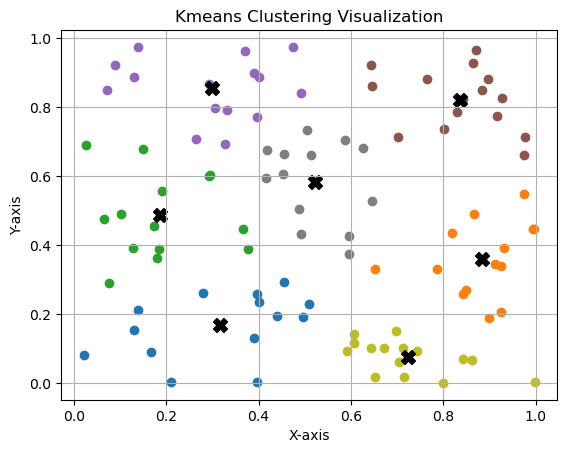

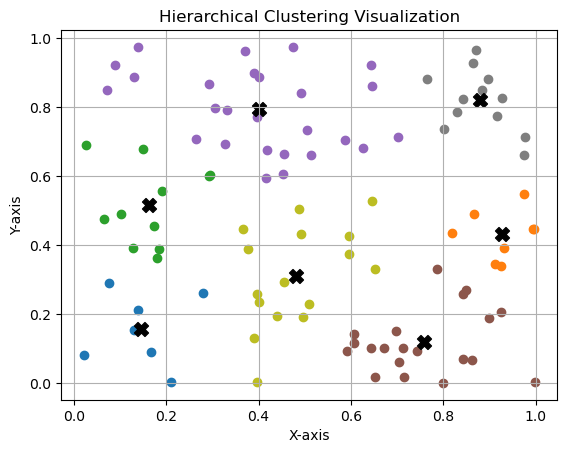

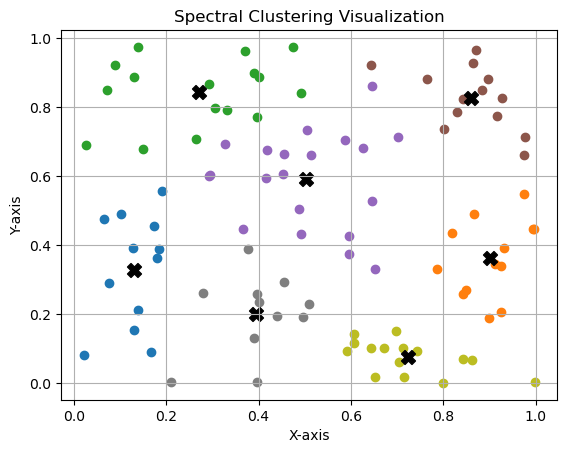

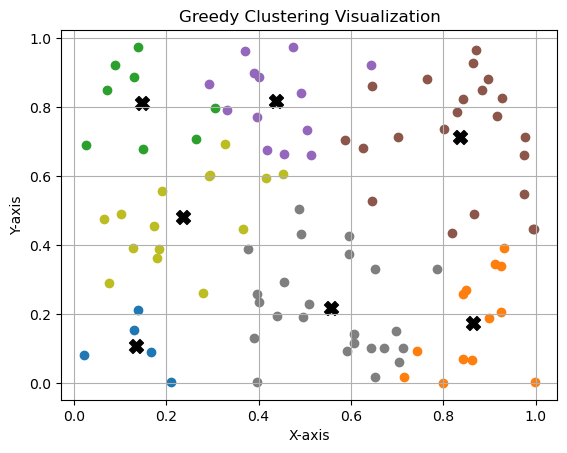

In [12]:
# Example test case
test_vertices = test_cases[0]

# Run K-Means Clustering without legends
vertices, cluster_assignments, selected_vertices = run_clustering(
    test_vertices, 
    num_clusters=num_clusters, 
    method='kmeans', 
    show_plot=True
)

# Run Hierarchical Clustering
vertices, cluster_assignments, selected_vertices = run_clustering(
    test_vertices, 
    num_clusters=num_clusters, 
    method='hierarchical', 
    show_plot=True
)

# Run Spectral Clustering
vertices, cluster_assignments, selected_vertices = run_clustering(
    test_vertices, 
    num_clusters=num_clusters, 
    method='spectral', 
    show_plot=True
)

# Run Greedy Clustering without legends
vertices, cluster_assignments, selected_vertices = run_clustering(
    test_vertices, 
    num_clusters=num_clusters, 
    method='greedy', 
    show_plot=True
)

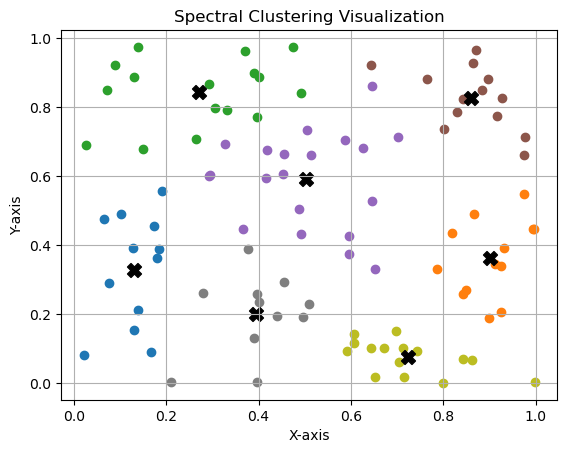

In [13]:
vertices, cluster_assignments, selected_vertices = run_clustering(
    test_vertices, 
    num_clusters=num_clusters, 
    method=clustering_method, 
    show_plot=True
)

### Run and Plot

In [14]:
def group_clusters(cluster_assignments, selected_vertices):
    # # Create a defaultdict to hold lists of keys for each value
    # value_to_keys = defaultdict(list)

    # # Iterate through the dictionary items
    # for key, value in d.items():
    #     value_to_keys[value].append(key)

    # # Create the result dictionary with value and keys
    # result = {value: [value] + keys for value, keys in value_to_keys.items()}

    # print(cluster_assignments)
    # print(selected_vertices)

    result = {}
    
    for key, value in cluster_assignments.items():
        if value not in result:
            result[value] = []
        result[value].append(key)
    
    # for elem in selected_vertices:
    #     if elem not in result:
    #         result[elem] = []
    #     result[elem].append(elem)

    return result

In [15]:
def run_subTSP(vertices, isCenter, isBold, show_plot):
    if isCenter:
        vertices = list(vertices.items())
    path, min_cost = simulated_annealing_tsp(vertices, isCenter)
    path += [path[-1]]

    if show_plot:
        # Now plot the TSP route on top
        for i in range(len(path)):
            start = path[i][1] if isCenter else path[i]
            end = path[(i + 1)%len(path)][1] if isCenter else path[(i + 1)%len(path)]
            if isBold:
                plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            else:
                plt.plot([start.x, end.x], [start.y, end.y], color='gray', linestyle='-', linewidth=1)
    
    return path

/tmp/ipykernel_327376/2116322686.py:71: RuntimeWarning: overflow encountered in scalar divide
  if random.random() < math.exp(-cost_diff / temp):


Center... done!
Size 11... done!
Size 12... done!
Size 16... done!
Size 20... done!
Size 13... done!
Size 13... done!
Size 15... done!


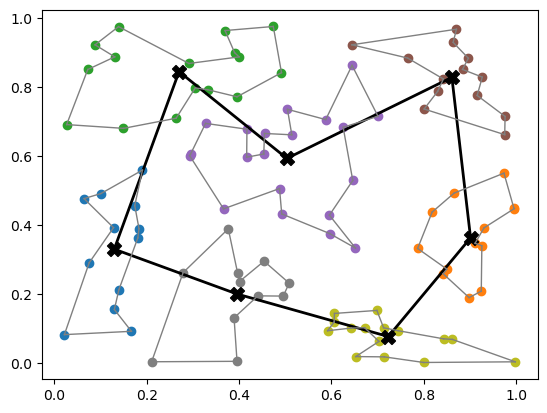

In [16]:
def run_inner_outer(vertices, cluster_assignments, selected_vertices, show_plot, print_log):
    path_data = []

    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

    path_data.append(run_subTSP(selected_vertices, True, True, show_plot))
    if print_log:
        print('Center... done!')

    clusters = group_clusters(cluster_assignments, selected_vertices)

    for center in path_data[0][:-1]:
        if print_log:
            print('Size ', len(clusters[center[0]]), '... ', sep='', end='')
        path_data.append(run_subTSP(clusters[center[0]], False, False, show_plot))
        if print_log:
            print('done!')

    path_data = path_data[1:]

    if show_plot:
        plt.show()

    return path_data

path_data = run_inner_outer(vertices, cluster_assignments, selected_vertices, True, True)

In [17]:
clusters = group_clusters(cluster_assignments, selected_vertices)
print(type(clusters[4][0]))

<class '__main__.Vertex'>


### Decide an Edge to Delete

For each edge in the cluster-level cycles, calculate **the distance from one end to the center of the previous cluster**, plus **the distance from the other end to the center of the next cluster**, and subtract **the length of the edge** to determine which edge to delete and how to connect to adjacent clusters.

In [18]:
# Function to calculate which edge to delete in the cluster cycle
def find_edge_to_delete(cycle, prev_center, next_center):
    min_total_distance = float('inf')
    edge_to_delete = None
    swap_order = None

    n = len(cycle)
    
    # Loop over all edges in the cycle.
    for i in range(n):
        start = cycle[i]
        end = cycle[(i + 1) % n]

        edge_length = start.distance_to(end)
        
        # Case 1: Original order (start -> end)
        dist_to_prev_center_case1 = start.distance_to(prev_center)
        dist_to_next_center_case1 = end.distance_to(next_center)
        total_distance_case1 = dist_to_prev_center_case1 + dist_to_next_center_case1 - edge_length
        
        # Case 2: Swapped order (end -> start)
        dist_to_prev_center_case2 = end.distance_to(prev_center)
        dist_to_next_center_case2 = start.distance_to(next_center)
        total_distance_case2 = dist_to_prev_center_case2 + dist_to_next_center_case2 - edge_length
        
        # Compare both cases and keep the best (minimum) one
        if total_distance_case1 < min_total_distance:
            min_total_distance = total_distance_case1
            edge_to_delete = i
            swap_order = False  # Indicates no swap in order
            
        if total_distance_case2 < min_total_distance:
            min_total_distance = total_distance_case2
            edge_to_delete = (i + 1) % n
            swap_order = True  # Indicates swap in order
    
    return edge_to_delete, swap_order

In [19]:
def run_deleteEdge(path_data):
    delete_edge = []

    for i in range(len(path_data)):
        edge_to_delete, swap_order = find_edge_to_delete(path_data[i], path_data[(i-1)%len(path_data)][0], path_data[(i+1)%len(path_data)][0])
        delete_edge.append((edge_to_delete, swap_order))

    actual_path = []

    for i in range(len(path_data)):
        path_data[i].pop()
        
        if delete_edge[i][1]:
            # Rotate to the right
            actual_path += path_data[i][delete_edge[i][0]:] + path_data[i][:delete_edge[i][0]]
        else:
            # Rotate to the left
            actual_path += path_data[i][delete_edge[i][0]::-1] + path_data[i][:delete_edge[i][0]:-1]
    
    return actual_path

actual_path = run_deleteEdge(path_data)

### Plot the Result

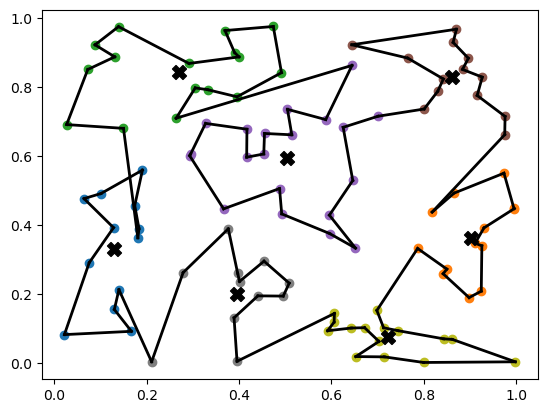

Distance: 9.778772198773044


In [20]:
def plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path, show_plot):
    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        # Now plot the TSP route on top
        for i in range(len(actual_path)):
            start = actual_path[i]
            end = actual_path[(i + 1) % len(actual_path)]
            plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            
        plt.show()

    dist_sol = 0
    for i in range(len(actual_path)):
        dist_sol += actual_path[i].distance_to(actual_path[(i+1)%len(actual_path)])

    return dist_sol

dist_sol = plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path, True)
print("Distance:", dist_sol)

In [21]:
# actual_path_2 = simulated_annealing_tsp(actual_path, begin_with_random=False)[0]
# dist_sol_2 = plot_final_path(vertices, cluster_assignments, selected_vertices, actual_path_2, True)
# print("Distance:", dist_sol_2)

### Compare with the Optimal Solution

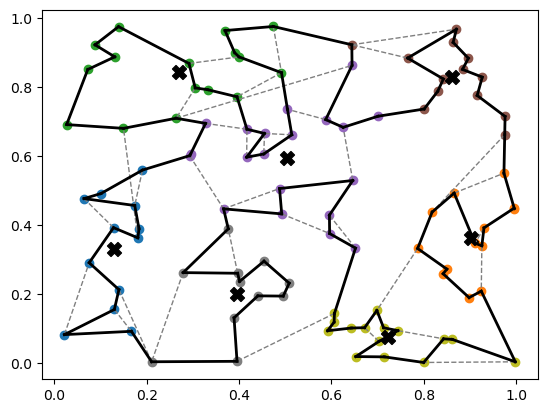

OPT = 8.186920621931955
SOL = 9.778772198773044
Rate = 1.1944383792578463


In [22]:
def compare_solution(vertices, cluster_assignments, selected_vertices, actual_path, optimum, show_plot):
    if show_plot:
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        # Now plot the TSP route on top
        for i in range(len(actual_path)):
            start = actual_path[i]
            end = actual_path[(i + 1) % len(actual_path)]
            plt.plot([start.x, end.x], [start.y, end.y], color='gray', linestyle='--', linewidth=1)

        # Now plot the TSP route on top
        for i in range(len(optimum)):
            start = optimum[i]
            end = optimum[(i + 1) % len(optimum)]
            plt.plot([start.x, end.x], [start.y, end.y], color='black', linestyle='-', linewidth=2)
            
        plt.show()

    dist_opt = 0
    for i in range(len(optimum)):
        dist_opt += optimum[i].distance_to(optimum[(i+1)%len(optimum)])
    return dist_opt

dist_opt = compare_solution(vertices, cluster_assignments, selected_vertices, actual_path, optimums[0], True)
print('OPT =', dist_opt)
print('SOL =', dist_sol)
print('Rate =', dist_sol/dist_opt)